In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import torch, gc

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 30

In [4]:
train_dataset = datasets.GTSRB(root='./data',
                                split="train",
                                transform = transforms.Compose([
                                    transforms.Resize((227, 227)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(1.,), std = (0.5 ))]),
                                download = True)
test_dataset = datasets.GTSRB(root='./data',
                                split="test",
                                transform = transforms.Compose([
                                    transforms.Resize((227, 227)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(1.,), std = (0.5 ))]),
                                download = True)

train_loader = DataLoader(dataset = train_dataset,
                          batch_size = batch_size,
                          shuffle = True)

test_loader = DataLoader(dataset = test_dataset,
                          batch_size = batch_size,
                          shuffle = True)

In [5]:
len(train_dataset)

26640

In [6]:
len(test_dataset)

12630

In [7]:
class AlexNet(nn.Module):
        def __init__(self, num_classes=10):
            super(AlexNet, self).__init__()
            self.layer1 = nn.Sequential(
                nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
                nn.BatchNorm2d(96),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.layer3 = nn.Sequential(
                nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer4 = nn.Sequential(
                nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(384),
                nn.ReLU())
            self.layer5 = nn.Sequential(
                nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size = 3, stride = 2))
            self.fc = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(9216, 4096),
                nn.ReLU())
            self.fc1 = nn.Sequential(
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU())
            self.fc2= nn.Sequential(
                nn.Linear(4096, num_classes))

        def forward(self, x):
            out = self.layer1(x)
            out = self.layer2(out)
            out = self.layer3(out)
            out = self.layer4(out)
            out = self.layer5(out)
            out = out.reshape(out.size(0), -1)
            out = self.fc(out)
            out = self.fc1(out)
            out = self.fc2(out)
            return out

In [8]:
gc.collect()
torch.cuda.empty_cache()

In [19]:
num_classes = 43
learning_rate = 0.001

model = AlexNet(num_classes).to(device)

cost = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

total_step = len(train_loader)

In [20]:
%%time
num_epochs = 25

loss_train = []
loss_test = []

for epoch in range(num_epochs):
    sum_loss = 0
    n_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = cost(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sum_loss += loss
        n_batches += 1

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    loss_train.append(sum_loss / n_batches)
    
    with torch.no_grad():
        sum_loss = 0
        n_batches = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = cost(outputs, labels)
            sum_loss += loss
            n_batches += 1
        loss_test.append(sum_loss / n_batches)

Epoch [1/25], Step [100/888], Loss: 3.2007
Epoch [1/25], Step [200/888], Loss: 2.3182
Epoch [1/25], Step [300/888], Loss: 1.8428
Epoch [1/25], Step [400/888], Loss: 1.4605
Epoch [1/25], Step [500/888], Loss: 0.9548
Epoch [1/25], Step [600/888], Loss: 0.5810
Epoch [1/25], Step [700/888], Loss: 0.5175
Epoch [1/25], Step [800/888], Loss: 0.2754
Epoch [2/25], Step [100/888], Loss: 0.2061
Epoch [2/25], Step [200/888], Loss: 0.1662
Epoch [2/25], Step [300/888], Loss: 0.0659
Epoch [2/25], Step [400/888], Loss: 0.2619
Epoch [2/25], Step [500/888], Loss: 0.0997
Epoch [2/25], Step [600/888], Loss: 0.1392
Epoch [2/25], Step [700/888], Loss: 0.0250
Epoch [2/25], Step [800/888], Loss: 0.2114
Epoch [3/25], Step [100/888], Loss: 0.0838
Epoch [3/25], Step [200/888], Loss: 0.0726
Epoch [3/25], Step [300/888], Loss: 0.0515
Epoch [3/25], Step [400/888], Loss: 0.0718
Epoch [3/25], Step [500/888], Loss: 0.0732
Epoch [3/25], Step [600/888], Loss: 0.0264
Epoch [3/25], Step [700/888], Loss: 0.0141
Epoch [3/25

In [21]:
%%time
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 26640 train images: {} %'.format(100 * correct / total))

Accuracy of the network on the 26640 train images: 100.0 %
CPU times: user 6min 14s, sys: 569 ms, total: 6min 14s
Wall time: 24 s


In [22]:
%%time
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 12630 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 12630 test images: 98.13143309580364 %
CPU times: user 2min 12s, sys: 140 ms, total: 2min 12s
Wall time: 8.46 s


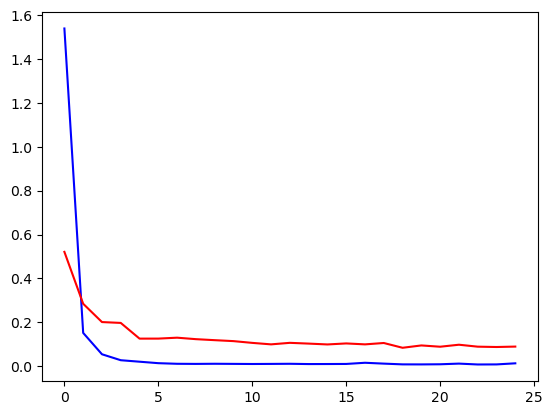

In [23]:
loss_train = np.array(torch.Tensor(loss_train))
loss_test = np.array(torch.Tensor(loss_test))

x = [i for i in range(num_epochs)]

fig, ax = plt.subplots()

ax.plot(x, loss_train, color='blue')
ax.plot(x, loss_test, color='red')